In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import time

# Download data

In [2]:
# Fetch MNIST dataset
from sklearn.datasets import fetch_openml

data_set = 'mnist'

if data_set == 'mnist':
    raw_data = fetch_openml('mnist_784')
else:
    assert False

In [3]:
raw_data_x = np.array((raw_data['data']+0.5)/256.0)
raw_data_y = np.array(raw_data['target'].astype('int8'))

# separate classes 0,1,2 into a new dataset
# accptbl_cats = (raw_data_y == 0) | (raw_data_y == 1)| (raw_data_y == 2)
accptbl_cats = (raw_data_y == 0) | (raw_data_y == 1)

raw_data_x = raw_data_x[accptbl_cats]
raw_data_y = raw_data_y[accptbl_cats]
num_classes = 2
img_sz = (28,28)

data_dim = raw_data_x.shape[1]

## Split data into training and validation

In [4]:
def display_image(x,lbl=None):
    plt.imshow(x.reshape(img_sz))
    plt.xticks([])
    plt.yticks([])
    if lbl is not None:
        plt.title(lbl)

def split_data(x,y,fracs=[0.8,0.2],seed=0):
    if seed is not None:
        np.random.seed(seed)
    N = x.shape[0]
    rp = np.random.permutation(N)

    N1 = int(fracs[0]*N)
    N2 = min(N-N1,int(fracs[1]*N))

    # Split the data into two parts
    x1 = x[rp[:N1]]
    y1 = y[rp[:N1]]
    x2 = x[rp[N1:(N1+N2)]]
    y2 = y[rp[N1:(N1+N2)]]

    return x1,y1,x2,y2

In [5]:
train_x,train_y,test_x,test_y = split_data(raw_data_x,raw_data_y,fracs=[0.01,0.01])
train_x,train_y,  val_x,val_y = split_data(train_x,train_y,fracs=[0.6,0.4])

In [6]:
print('num_train = ' + str(train_x.shape[0]))
print('num_val = ' + str(val_x.shape[0]))
print('num_test = ' + str(test_x.shape[0]))
print('num_classes = '+str(num_classes))

num_train = 88
num_val = 58
num_test = 147
num_classes = 2


# Explore the data

48.86% of the training data is class 0, corresponding to 43 data points
51.14% of the training data is class 1, corresponding to 45 data points


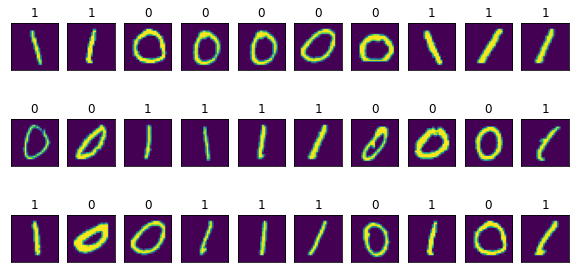

In [7]:
# Print statistics
num_train = len(train_y)
for i in range(num_classes):
    num_class_i = np.sum(train_y == i)
    print('{:.2f}% of the training data is class {}, corresponding to {} data points'.format(100*num_class_i/num_train,
                                                                                       i, num_class_i))

# Visualize a few images
np.random.seed(0)
num_digits = 10
num_rows = 3
plt.figure(figsize=(10,5))
for i in range(num_rows*num_digits):
    ind = np.random.randint(0,train_x.shape[0])
    plt.subplot(num_rows,num_digits,i+1)
    display_image(train_x[ind,:],
                train_y[ind])



# Extract SIFT keypoints and descriptors

## Prepare data

In [8]:
# convert train images to 2D with [0,255] color values
train_x_sift = ((train_x.reshape((train_x.shape[0], img_sz[0], img_sz[1], 1)))*256).astype('uint8')
train_x_sift = np.broadcast_to(train_x_sift, (train_x.shape[0], img_sz[0], img_sz[1], 3))

In [9]:
def display_color_image(img, lbl=None):
    plt.imshow(img.reshape((img_sz[0], img_sz[1], 3)))
    plt.xticks([])
    plt.yticks([])
    if lbl is not None:
        plt.title(lbl)

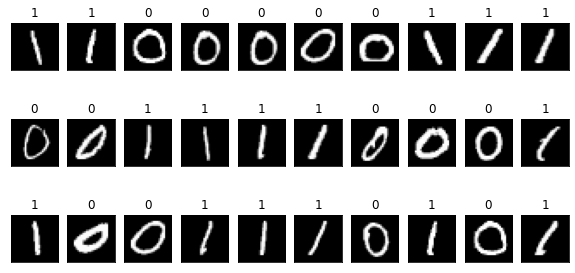

In [10]:
# Visualize a few images
np.random.seed(0)
num_digits = 10
num_rows = 3
plt.figure(figsize=(10,5))
for i in range(num_rows*num_digits):
    ind = np.random.randint(0,train_x_sift.shape[0])
    plt.subplot(num_rows,num_digits,i+1)
    display_color_image(train_x_sift[ind], train_y[ind])

## Extract SIFT keypoints and descriptors

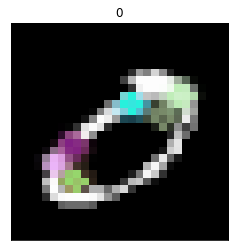

In [11]:
# extract SIFT descriptors for one image
gray= cv.cvtColor(train_x_sift[0],cv.COLOR_BGR2GRAY)

# SIFT with default parameter values
sift = cv.SIFT_create(nfeatures = 0, nOctaveLayers = 3, contrastThreshold = 0.04, edgeThreshold = 10, sigma = 1.6)

# SIFT with custom parameter values
# sift = cv.SIFT_create(nfeatures = 0, nOctaveLayers = 20, contrastThreshold = 0.04, edgeThreshold = 5, sigma = 1.6)

kp, des = sift.detectAndCompute(gray,None)
img=cv.drawKeypoints(gray,kp,0,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
display_color_image(img, train_y[0])

In [12]:
# extract SIFT descriptors for all training data
gray = np.array([cv.cvtColor(train_x_sift[0],cv.COLOR_BGR2GRAY)])
for i in range(1, train_x_sift.shape[0]):
    gray = np.append(gray, [cv.cvtColor(train_x_sift[i],cv.COLOR_BGR2GRAY)], axis=0)
kp = []
des = []
for i in range(gray.shape[0]):
    _kp, _des = sift.detectAndCompute(gray[i],None)
    kp.append(_kp)
    des.append(_des)

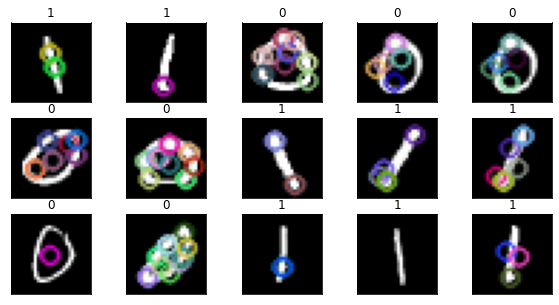

In [13]:
# visualize a few keypoints
np.random.seed(0)
num_digits = 5
num_rows = 3
plt.figure(figsize=(10,5))
for i in range(num_rows*num_digits):
    ind = np.random.randint(0,gray.shape[0])
    plt.subplot(num_rows,num_digits,i+1)
    img=cv.drawKeypoints(gray[ind],kp[ind],0)
    #img=cv.drawKeypoints(gray[ind],kp[ind],0,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    display_color_image(img, train_y[ind])

In [14]:
# show statistics of the number of keypoints found in each training image
num_keypoints = [len(kp[i]) for i in range(len(kp))]
print('# of training images: '+ str(len(num_keypoints)))
print('min # of keypoints: ' + str(min(num_keypoints)))
print('max # of keypoints: ' + str(max(num_keypoints)))
for i in range(2):
    temp = np.sum([k==i for k in num_keypoints])/len(num_keypoints)*100
    print('{:.1f}% of training images have {} keypoints'.format(temp, i))

# of training images: 88
min # of keypoints: 0
max # of keypoints: 21
5.7% of training images have 0 keypoints
2.3% of training images have 1 keypoints


## Select only two keypoints for each image

1. Discard all images with less than two keypoints.
2. Select keypoints closest to the top-left and bottom-right corners. This method will hopefully cover the greatest possible area of the image.
3. Concatenate two descriptors (of size 128) to form one feature vector (of size 256) for each image

In [15]:
# discard all images that have less than 2 keypoints
to_discard_ind = [i for i in range(len(num_keypoints)) if (num_keypoints[i]==0 or num_keypoints[i]==1)]
train_x_sift_mod = np.delete(train_x_sift, to_discard_ind, axis=0)
train_y_mod = np.delete(train_y, to_discard_ind, axis=0)
gray_mod = np.delete(gray, to_discard_ind, axis=0)
kp_mod = [kp[i] for i in range(len(kp)) if i not in to_discard_ind]
des_mod = [des[i] for i in range(len(des)) if i not in to_discard_ind]

In [16]:
# show statistics of the number of keypoints found in each training image
# num_keypoints_mod = [len(kp_mod[i]) for i in range(len(kp_mod))]
# print('# of training images: '+ str(len(num_keypoints_mod)))
# print('min # of keypoints: ' + str(min(num_keypoints_mod)))
# print('max # of keypoints: ' + str(max(num_keypoints_mod)))
# for i in range(2):
#     temp = np.sum([k==i for k in num_keypoints_mod])/len(num_keypoints_mod)*100
#     print('{:.1f}% of training images have {} keypoints'.format(temp, i))

In [17]:
# select only two keypoints in all images with more than 2 keypoints
for i in range(len(kp_mod)): # for each training images
    # calculate keypoint's distance from the top-left and bottom-right corners
    left_dists = [(kp_mod[i][j], np.sum(np.array(kp_mod[i][j].pt)**2), des_mod[i][j]) for j in range(len(kp_mod[i]))]
    right_dists = [(kp_mod[i][j], np.sum(np.array([img_sz[0]-kp_mod[i][j].pt[0], img_sz[1]-kp_mod[i][j].pt[1]])**2), \
                    des_mod[i][j]) for j in range(len(kp_mod[i]))]
    
    # select closest keypoints to the top-left and bottom-right corners, discard all other keypoints
    kp_mod[i] = (min(left_dists, key=lambda x:x[1])[0], min(right_dists, key=lambda x:x[1])[0])
    des_mod[i] = np.array([min(left_dists, key=lambda x:x[1])[2], min(right_dists, key=lambda x:x[1])[2]])
    
    # concatenate two descriptors
    des_mod[i] = des_mod[i].reshape(-1)

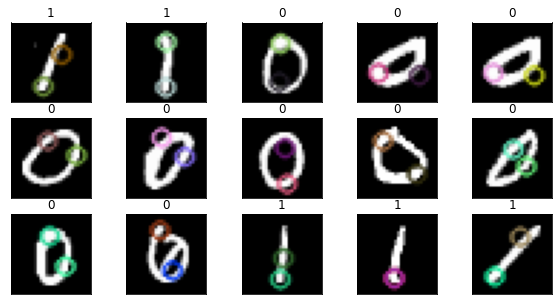

In [18]:
# visualize a few keypoints
np.random.seed(0)
num_digits = 5
num_rows = 3
plt.figure(figsize=(10,5))
for i in range(num_rows*num_digits):
    ind = np.random.randint(0,gray_mod.shape[0])
    plt.subplot(num_rows,num_digits,i+1)
    img=cv.drawKeypoints(gray_mod[ind],kp_mod[ind],0)
    #img=cv.drawKeypoints(gray_mod[ind],kp_mod[ind],0,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    display_color_image(img, train_y_mod[ind])

In [19]:
# show statistics of the number of keypoints found in each training image
num_keypoints_mod = [len(kp_mod[i]) for i in range(len(kp_mod))]
print('# of training images: '+ str(len(num_keypoints_mod)))
print('min # of keypoints: ' + str(min(num_keypoints_mod)))
print('max # of keypoints: ' + str(max(num_keypoints_mod)))
for i in range(2):
    temp = np.sum([k==i for k in num_keypoints_mod])/len(num_keypoints_mod)*100
    print('{:.1f}% of training images have {} keypoints'.format(temp, i))

# of training images: 81
min # of keypoints: 2
max # of keypoints: 2
0.0% of training images have 0 keypoints
0.0% of training images have 1 keypoints


In [20]:
# save feature vectors and labels of all images
np.savetxt('../../data/des.txt', np.array(des_mod))
np.savetxt('../../data/lbls.txt', train_y_mod)

## Normalize feature vectors

### Method 1: Normalize l1-norm of each vector to 1.

In [21]:
# # method 1: normalize l1-norm of each vector to 1.
# des_mod_nrm = np.array([d/np.sum(d) for d in des_mod])

### Method 2: Double normalization
    2.1. Feature-wise: Subtract mean and divide by standard deviation of each feature in all samples.
    2.2. Sample-wise: Normalize l2-norm of each vector to 1.

In [22]:
# method 2: double normalization
# step 1 - feature-wise: subtract mean and divide by standard deviation of each feature.
des_mod_nrm = np.array(des_mod)
des_mod_nrm = des_mod_nrm - np.mean(des_mod_nrm, axis=0, keepdims=True)
des_mod_nrm = des_mod_nrm / np.std(des_mod_nrm, axis=0, keepdims=True)


# step 2 - smaple-wise: normalize l2-norm of each vector to 1.
des_mod_nrm = des_mod_nrm / np.linalg.norm(des_mod_nrm, axis=1, keepdims=True)

# Learn similarity graph with gradient descent

## Unconstrained optimization 1

#### Loss function: $ \min_{L} \frac{x^T L x}{x^T x} $ 

#### Where $L$ is the graph Laplacian and $x$ is image labels (1 for 1 and -1 for 0)

In [23]:
def rayleigh(L, x, deriv=False):
    """ 
    Compute Rayleigh quotient and its derivative w.r.t. L
    
    Input: L, x, deriv
    L - NxN matrix
    x - Nx1 vector
    deriv - whether or not to compute and do the derivative
    
    Output: if deriv: r, dr
                else: r
    r - value of Rayleigh quotient
    dr - derivative of Rayleight quotient w.r.t. L    
    """
    
    assert len(L) == len(x)
    assert len(L[0]) == len(x)
    
    r = (x.T @ L @ x)/(x.T @ x)
    
    if deriv:
        X = np.broadcast_to([x], (len(x), len(x))).T
        dr = ((X - X.T)**2)/(x.T @ x)
        return r,dr
    else:
        return r

    

## Unconstrained optimization 2

#### Loss function: $ \min_{B} \frac{x^T L x}{x^T x} $ 

#### Positive semi-definite condition: $L = B^T B$

#### Where $L$ is the graph Laplacian and $x$ is image labels (1 for 1 and -1 for 0)

In [24]:
def rayleigh_psd(B, x, deriv=False):
    """ 
    Compute Rayleigh quotient and its derivative w.r.t. B
    Assuming L = B^T @ B
    
    Input: B, x, deriv
    B - NxN matrix
    x - Nx1 vector
    deriv - whether or not to compute and do the derivative
    
    Output: if deriv: r, dr
                else: r
    r - value of Rayleigh quotient
    dr - derivative of Rayleight quotient w.r.t. B   
    """
    
    assert len(B) == len(x)
    assert len(B[0]) == len(x)

    r = (x.T @ B.T @ B @ x)/(x.T @ x)
    
    if deriv:
        X = np.broadcast_to([x], (len(x), len(x))).T
        X = ((X - X.T)**2)/(x.T @ x)
        dr = 2 * (B @ X)
        
        return r,dr
    else:
        return r
 

## Unconstrained optimization 3

#### Loss function: $ \min_{B} x^T L x$ 

#### Given $B$, we have:

#### Positive semi-definite condition: $M = B^T B$

#### Edge weights are $ w_{ij} = exp\left( (f_i - f_j)^T M (f_i - f_j) \right) $

#### Where $ f_i $ is a feature vector for image $i$

#### Graph Laplacian is $L = diag(W 1) - W$  and $x$ is image labels (1 for 1, and -1 for 0)

### Refer to Yasaman's notes for derivation

In [25]:
def rayleigh_LWMB(B, f, x, deriv=False):
    """ 
    Compute Rayleigh quotient and its derivative w.r.t. B
    Assuming M = B^T @ B
    
    Input: B, f, x, deriv
    B - NxN matrix of parameters determining the covariance matrix (M=B.T @ B)
    f - CxN matrix of feature vectors (Cx1) for all N training images
    x - Nx1 vector of image labels (1 for 1; -1 for 0)
    deriv - whether or not to compute and do the derivative
    
    Output: if deriv: r, dr
                else: r
    r - value of un-normalized Rayleigh quotient (x.T @ L @ x)
    dr - derivative of un-normalized Rayleight quotient w.r.t. B
    """
    
    # Some additional matrices:
    # F - NxNxC matrix of difference of feature vectors for each pair of training images
    # M - CxC matrix of covariance of each pair of training images; M = B.T @ B
    # W - NxN adjacency matrix of the graph; w_ij = exp((F_ij.T @ M @ F_ij) / (F_ij.T @ F_ij))
    # D - NxN degree matrix of graph; D = diag(W @ 1)
    # L - NxN graph laplacian matrix; L = D - W
    # Q - NxN auxiliary matrix to compute dr
    # X - NxN auxiliary matrix to compute dr
    
    # create F
    f_sz, num_train = f.shape
    Fj = np.broadcast_to([f.T], (num_train, num_train, f_sz))
    Fi = np.transpose(Fj, (1,0,2))
    F = Fi - Fj
    
    # create M
    M = B.T @ B

    # create W and Q
    W = np.zeros((num_train, num_train))
    Q = np.zeros((num_train, num_train))
    for i in range(num_train):
        for j in range(num_train):
            if i==j:
                W[i][j] = 0
                Q[i][j] = 0
            else:
                phi_sq = np.sum(F[i][j].T @ F[i][j]) + 0.01
                W[i][j] = np.exp((F[i][j].T @ M @ F[i][j])/phi_sq)
                Q[i][j] = (1/phi_sq) * W[i][j]
    
            
#     # create W - EACH ROUND TAKES ABOUT 10 MIN; MAYBE LESS MEMORY USAGE
#     fmf = np.einsum('ija,ijk,ak->ij',F,F,M)
#     nrmsq_f = np.einsum('ijk,ijk->ij',F,F)
#     W = np.exp(fmf / nrmsq_f)
    
#     # create W - KERNEL DIES
#     temp = np.tensordot(F,M, axes=([2],[1]))
#     fmf = np.sum(F * temp, axis=2)
#     nrmsq_f = np.sum(F * F, axis=2)
#     W = np.exp(fmf/nrmsq_f)
            
    # create L
    D = np.diag(W @ np.ones(num_train))
    L = D - W
    
    # calculate r
    r = x.T @ L @ x
    
    
    if deriv:
        
        # create X
        X = np.broadcast_to([x], (len(x), len(x))).T
        X = ((X - X.T)**2)
        
        # calculate drdM - TAKES TOO LONG
        QX = np.multiply(Q, X)
        drdM = np.zeros((f_sz, f_sz))
        for s in range(f_sz):
            for t in range(f_sz):
                Fst = np.multiply(F[:,:,s], F[:,:,t])
                drdM[s][t] = -1 * np.sum(np.multiply(QX, Fst))
                
        # calculate dr w.r.t B
        dr = B @ (drdM + drdM.T)
        
        
        return r,dr
    else:
        return r

## Unconstrained optimization 4

#### Loss function: $\min_{B} x^T L x $ 

#### Given $ B $, we have:

#### Positive semi-definite condition: $M = B^T B$

#### Edge weights are $ w_{ij} = exp\left( - (f_i - f_j)^T M (f_i - f_j) \right) $

#### Where $ f_i $ is a feature vector for image $i$

#### Graph Laplacian is $L = diag(W 1) - W$  and $x$ is image labels (1 for 1, and -1 for 0)

### Refer to Yasaman's notes for derivation

In [26]:
 def rayleigh_LWMB_neg(B, f, x, deriv=False):
    """ 
    Compute Rayleigh quotient and its derivative w.r.t. B
    Assuming M = B^T @ B
    
    Input: B, f, x, deriv
    B - NxN matrix of parameters determining the covariance matrix (M=B.T @ B)
    f - CxN matrix of feature vectors (Cx1) for all N training images
    x - Nx1 vector of image labels (1 for 1; -1 for 0)
    deriv - whether or not to compute and do the derivative
    
    Output: if deriv: r, dr
                else: r
    r - value of un-normalized Rayleigh quotient (x.T @ L @ x)
    dr - derivative of un-normalized Rayleight quotient w.r.t. B
    """
    
    # Some additional matrices:
    # F - NxNxC matrix of difference of feature vectors for each pair of training images
    # M - CxC matrix of covariance of each pair of training images; M = B.T @ B
    # W - NxN adjacency matrix of the graph; w_ij = exp(- F_ij.T @ M @ F_ij)
    # D - NxN degree matrix of graph; D = diag(W @ 1)
    # L - NxN graph laplacian matrix; L = D - W
    # X - NxN auxiliary matrix to compute dr
    
    # create F
    f_sz, num_train = f.shape
    Fj = np.broadcast_to([f.T], (num_train, num_train, f_sz))
    Fi = np.transpose(Fj, (1,0,2))
    F = Fi - Fj
    
    # create M
    M = B.T @ B

    # create W
    W = np.zeros((num_train, num_train))
    for i in range(num_train):
        for j in range(num_train):
            if i==j:
                W[i][j] = 0
            else:
                W[i][j] = np.exp(-1*(F[i][j].T @ M @ F[i][j]))

    
#     # create W - EACH ROUND TAKES ABOUT 10 MIN; MAYBE LESS MEMORY USAGE
#     fmf = np.einsum('ija,ijk,ak->ij',F,F,M)
#     nrmsq_f = np.einsum('ijk,ijk->ij',F,F)
#     W = np.exp(fmf / nrmsq_f)
    
#     # create W - KERNEL DIES
#     temp = np.tensordot(F,M, axes=([2],[1]))
#     fmf = np.sum(F * temp, axis=2)
#     nrmsq_f = np.sum(F * F, axis=2)
#     W = np.exp(fmf/nrmsq_f)
            
    # create L
    D = np.diag(W @ np.ones(num_train))
    L = D - W
    
    # calculate r
    r = x.T @ L @ x
    
    if deriv:
        
        # create X
        X = np.broadcast_to([x], (len(x), len(x))).T
        X = ((X - X.T)**2)
        
        # calculate drdM - TAKES TOO LONG
        XW = np.multiply(X, W)
        drdM = np.zeros((f_sz, f_sz))
        for s in range(f_sz):
            for t in range(f_sz):
                Fst = np.multiply(F[:,:,s], F[:,:,t])
                drdM[s][t] = np.sum(np.multiply(XW, Fst))
                
        # calculate dr w.r.t B
        dr = B @ (drdM + drdM.T)
        
        
        return r,dr
    else:
        return r

## Constrained optimization 1

#### Loss function: $ \min_{B} x^T L x + \mu \; tr(M)$ 

#### Given $ B $, we have:

#### Positive semi-definite condition: $M = B^T B$

#### Edge weights are $ w_{ij} = exp\left( - (f_i - f_j)^T M (f_i - f_j) \right) $

#### Where $ f_i $ is a feature vector for image $i$

#### Graph Laplacian is $L = diag(W 1) - W$  and $x$ is image labels (1 for 1, and -1 for 0)

#### The constraint $\mu \; tr(M)$ prevents $M$ entries from going to infinity

### Refer to Yasaman's notes for derivation

In [27]:
def rayleigh_tr(B, f, x, mu=1, deriv=False):
    """ 
    Compute loss function and its derivative w.r.t. B
    Loss = x.T @ L @ x + mu * tr(M)
    Assuming M = B^T @ B
    
    Input: B, f, x, mu, deriv
    B - NxN matrix of parameters determining the covariance matrix (M=B.T @ B)
    f - CxN matrix of feature vectors (Cx1) for all N training images
    x - Nx1 vector of image labels (1 for 1; -1 for 0)
    mu - scalar parameter of the loss function
    deriv - whether or not to compute and do the derivative
    
    Output: if deriv: E, dE
                else: E
    E - loss value with current B
    dE - derivative of loss function w.r.t. B at current B
    """
    
    # Some additional matrices:
    # F - NxNxC matrix of difference of feature vectors for each pair of training images
    # M - CxC matrix of covariance of each pair of training images; M = B.T @ B
    # W - NxN adjacency matrix of the graph; w_ij = exp(- F_ij.T @ M @ F_ij)
    # D - NxN degree matrix of graph; D = diag(W @ 1)
    # L - NxN graph laplacian matrix; L = D - W
    # X - NxN auxiliary matrix to compute dr
    
    # create F
    f_sz, num_train = f.shape
    Fj = np.broadcast_to([f.T], (num_train, num_train, f_sz))
    Fi = np.transpose(Fj, (1,0,2))
    F = Fi - Fj
    
    # create M
    M = B.T @ B

    # create W
    W = np.zeros((num_train, num_train))
    for i in range(num_train):
        for j in range(num_train):
            if i==j:
                W[i][j] = 0
            else:
                W[i][j] = np.exp(-1*(F[i][j].T @ M @ F[i][j]))

    
#     # create W - EACH ROUND TAKES ABOUT 10 MIN; MAYBE LESS MEMORY USAGE
#     fmf = np.einsum('ija,ijk,ak->ij',F,F,M)
#     nrmsq_f = np.einsum('ijk,ijk->ij',F,F)
#     W = np.exp(fmf / nrmsq_f)
    
#     # create W - KERNEL DIES
#     temp = np.tensordot(F,M, axes=([2],[1]))
#     fmf = np.sum(F * temp, axis=2)
#     nrmsq_f = np.sum(F * F, axis=2)
#     W = np.exp(fmf/nrmsq_f)
            
    # create L
    D = np.diag(W @ np.ones(num_train))
    L = D - W
    
    # calculate r
    r = x.T @ L @ x
    
    # calculate E
    E = r + mu * np.trace(M)
    
    if deriv:
        
        # create X
        X = np.broadcast_to([x], (len(x), len(x))).T
        X = ((X - X.T)**2)
        
        # calculate drdM - TAKES TOO LONG
        XW = np.multiply(X, W)
        drdM = np.zeros((f_sz, f_sz))
        for s in range(f_sz):
            for t in range(f_sz):
                Fst = np.multiply(F[:,:,s], F[:,:,t])
                drdM[s][t] = np.sum(np.multiply(XW, Fst))
                
        # calculate dr w.r.t. B
        drdB = B @ (drdM + drdM.T)
        
        # calculate dE w.r.t. B
        dE = drdB + 2 * mu * B
        
        return E,dE
    else:
        return E

## Gradient descent algorithm

In [28]:
# define a general gradient descent method
def gradient_descent(loss_func, opt_params):
    """
    Learn a set of parameters using gradient descent.

    Inputs: loss_func, opt_params
    loss_func - loss function to use for training; it should only take one input which is optimization parameter
    opt_params - parameters of the training algorithm (see below)

    Outputs: Theta, stats
    Theta - parameters at the end of optimization
    stats - dictionary of various statistics computed during training to be used
            for visualization and analysis
    """

    # Optimization parameters in opt_params
    epsilon0 = opt_params['epsilon0'] # starting learning rate for GD
    epsilon_decay = opt_params['epsilon_decay'] # decay factor for GD learning rate
    epsilon_jump = opt_params['epsilon_jump'] # decay factor for GD learning rate
    num_its = opt_params['num_its'] # number of iterations to run
    Theta0 = opt_params['Theta0'] # initial value for the parameters, can be None to randomly initialize
    check_freq = opt_params['check_freq'] # how frequently to compute and print out statistics of learning
    print_checks = opt_params['print_checks'] # print info out when checkpointing
    seed = opt_params['seed'] if 'seed' in opt_params else 0

    if seed is not None:
        np.random.seed(seed)

    check_its = []
    check_times = []
    check_Thetas = []
    train_losss = []
    it_times = []
    epsilon = epsilon0
    start_t = time.time()
    Theta = Theta0
    for it in range(num_its):
        
#         print('new it:')
#         print('Theta = '+str(Theta))
        
        # Compute loss and its derivative with current parameter values
        E, dEdTheta = loss_func(Theta, deriv=True)

#         print('E = ' + str(E))
#         print('dEdTheta = ' + str(dEdTheta))
        
        # Find epsilon which decreases train loss
        epsilon *= epsilon_jump
        
#         print('epsilon = '+str(epsilon))
        
        new_E = np.inf
        while new_E > E:
            # Update parameters with the GD update
            Theta1 = Theta - epsilon * dEdTheta
#             print('Theta1 = '+str(Theta1))
 
            new_E = loss_func(Theta1, deriv=False)
#             print('new_E = '+str(new_E))
        
            epsilon *= epsilon_decay
#             print('epsilon = '+str(epsilon))

        # Replace old value of Theta with new one
        Theta = Theta1
#         print('final Theta = '+str(Theta))
        
        # Compute the norm of the entire gradient to monitor
        nrmsq_dEdTheta = np.sum(dEdTheta**2)
        
        # Restore epsilon's working value 
        epsilon /= epsilon_decay

        if it%check_freq == 0 or it+1 == num_its:
            # Periodically compute the training loss/accuracy on the _full_ dataset
            # for reference.  Note this is rarely done in practice because it isn't
            # possible or is hugely impractical.  We're just doing it here to see 
            # how it relates to the values computed with a mini-batch
            E = loss_func(Theta, deriv=False)

            check_Thetas.append(Theta)
            check_its.append(it)
            check_times.append(time.time() - start_t)
            train_losss.append(E)

            if print_checks:
                print("{:4}: eps = {:.2e};"
                      "  train loss (E) = {:5.2f};"
                      "  ||dEdTheta|| = {:5.2f}".format(it, epsilon,
                                                        E, 
                                                        np.sqrt(nrmsq_dEdTheta)))
        it_times.append(time.time() - start_t)

    stats = { 'check_its':check_its, # Iteration numbers of checkpoints
            'check_times':check_times, # wall clock time of checkpoints
            'check_Thetas':check_Thetas, # Theta values at checkpoints
            'it_times':it_times, # wall clock time of each iteration
            'train_losss':train_losss} # loss of full training set at checkpoint iterations
    
    return Theta, stats

## Fit graph via gradient descent

In [29]:
def display_matrix(M, lbl=None):
    
    plt.figure(figsize=(6,6))
    plt.imshow(M)
    plt.colorbar()
    if lbl is not None:
        plt.title(lbl)

In [30]:
# def fit_graph_with_rayleigh_psd(train_x, train_y, opt_params, show_L=False):  
    
#     B0 = opt_params['Theta0']
    
#     if B0 is None:
#         num_train = len(train_x)
#         B0 = np.random.randn(num_train,num_train)
#         opt_params['Theta0'] = B0
        
#     def rayleigh_psd_wrap(B, deriv=False):
#         x = train_y*2-1
#         return rayleigh_psd(B, x, deriv)
    
#     B, stats = gradient_descent(rayleigh_psd_wrap, opt_params)
    
#     if show_L:
#         L = B.T @ B
#         Bs = stats['check_Thetas']
#         Ls = [(b.T @ b) for b in Bs]
#         stats['check_Thetas'] = Ls
    
#         return L, stats
#     else:
#         return B, stats
    
# # learn B (L = B.T @ B) with GD
# B0 = np.ones((len(train_y_mod), len(train_y_mod)))
# opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 1.5,
#                'num_its':101, 'check_freq':10, 'print_checks':True, 'Theta0':None }
# B, stats = fit_graph_with_rayleigh_psd(train_x_sift_mod, train_y_mod, opt_params)

In [31]:
# def fit_graph_with_rayleigh_LWMB(train_x, train_y, des, opt_params, show_L=False):  
    
#     B0 = opt_params['Theta0']

#     if B0 is None:
#         num_train, f_sz = des.shape
#         B0 = 100000000*np.random.random_sample((f_sz,f_sz))
#         opt_params['Theta0'] = B0

#     def rayleigh_LWMB_wrap(B, deriv=False):
#         x = train_y*2-1
#         f = des.T
#         return rayleigh_LWMB(B, f, x, deriv)

#     B, stats = gradient_descent(rayleigh_LWMB_wrap, opt_params)

#     if show_L:
#         L = B.T @ B
#         Bs = stats['check_Thetas']
#         Ls = [(b.T @ b) for b in Bs]
#         stats['check_Thetas'] = Ls

#         return L, stats
#     else:
#         return B, stats
    
    
# f_sz = des_mod_nrm.shape[1]
# B0 = 100000000*np.ones((f_sz, f_sz))
# opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 3,
#                'num_its':101, 'check_freq':10, 'print_checks':True, 'Theta0':None }
# B, stats = fit_graph_with_rayleigh_LWMB(train_x_sift_mod, train_y_mod, des_mod_nrm, opt_params)

In [32]:
# def fit_graph_with_rayleigh_LWMB_neg(train_x, train_y, des, opt_params, show_L=False):  
    
#     B0 = opt_params['Theta0']

#     if B0 is None:
#         num_train, f_sz = des.shape
#         B0 = 0.0001*np.random.random_sample((f_sz,f_sz))
#         opt_params['Theta0'] = B0
#         display_matrix(B0, 'B0')

#     def rayleigh_LWMB_neg_wrap(B, deriv=False):
#         x = train_y*2-1
#         f = des.T
#         return rayleigh_LWMB_neg(B, f, x, deriv)

#     B, stats = gradient_descent(rayleigh_LWMB_neg_wrap, opt_params)

#     if show_L:
#         L = B.T @ B
#         Bs = stats['check_Thetas']
#         Ls = [(b.T @ b) for b in Bs]
#         stats['check_Thetas'] = Ls

#         return L, stats
#     else:
#         return B, stats
    
    
# f_sz = des_mod_nrm.shape[1]
# B0 = 0.0001*np.ones((f_sz, f_sz))
# opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 1.5,
#                'num_its':10, 'check_freq':1, 'print_checks':True, 'Theta0':None }
# B, stats = fit_graph_with_rayleigh_LWMB_neg(train_x_sift_mod, train_y_mod, des_mod_nrm, opt_params)

   0: eps = 7.50e-01;  train loss (E) = 2213.71;  ||dEdTheta|| = 62.73
   1: eps = 5.62e-01;  train loss (E) = 111.12;  ||dEdTheta|| = 94.51
   2: eps = 7.32e-19;  train loss (E) = 111.12;  ||dEdTheta|| = 158.31
   3: eps = 6.86e-20;  train loss (E) = 111.12;  ||dEdTheta|| = 158.31
   4: eps = 5.15e-20;  train loss (E) = 111.12;  ||dEdTheta|| = 158.31
   5: eps = 1.54e-19;  train loss (E) = 111.12;  ||dEdTheta|| = 158.31
   6: eps = 2.32e-19;  train loss (E) = 111.12;  ||dEdTheta|| = 158.31
   7: eps = 6.95e-19;  train loss (E) = 111.12;  ||dEdTheta|| = 158.31
   8: eps = 2.61e-19;  train loss (E) = 111.12;  ||dEdTheta|| = 158.31
   9: eps = 7.82e-19;  train loss (E) = 111.12;  ||dEdTheta|| = 158.31


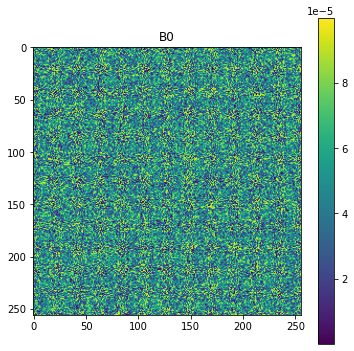

In [33]:
def fit_graph_with_rayleigh_tr(train_x, train_y, des, opt_params, show_L=False):  
    
    B0 = opt_params['Theta0']

    if B0 is None:
        num_train, f_sz = des.shape
        B0 = 0.0001*np.random.random_sample((f_sz,f_sz))
        opt_params['Theta0'] = B0
    
    display_matrix(B0, 'B0')

    def rayleigh_tr_wrap(B, deriv=False):
        x = train_y*2-1
        f = des.T
        mu = 1
        return rayleigh_tr(B, f, x, mu, deriv)

    B, stats = gradient_descent(rayleigh_tr_wrap, opt_params)

    if show_L:
        L = B.T @ B
        Bs = stats['check_Thetas']
        Ls = [(b.T @ b) for b in Bs]
        stats['check_Thetas'] = Ls

        return L, stats
    else:
        return B, stats
    
    
f_sz = des_mod_nrm.shape[1]
B0 = 1*np.ones((f_sz, f_sz))
opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 3,
               'num_its':10, 'check_freq':1, 'print_checks':True, 'Theta0':None }
B, stats = fit_graph_with_rayleigh_tr(train_x_sift_mod, train_y_mod, des_mod_nrm, opt_params)

## Display learned parameters

In [34]:
def hist_of_entries(M, num_bins, lx=None, lbl=None):
    
    plt.figure()
    _ = plt.hist(M.reshape(-1),num_bins)
    
    if lx is not None:
        plt.xlim([-lx, lx])
    
    if lbl is not None:
        _ = plt.title(lbl)

B_max = 0.13150140566321725	B_min = -0.12153629157659211
M_max = 0.6325783119519895	M_min = -0.5621381521911564


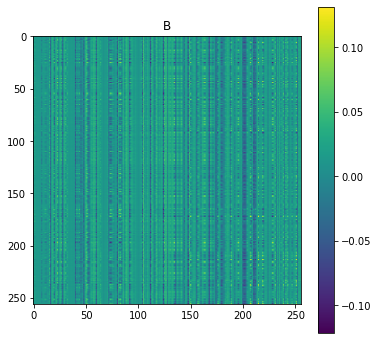

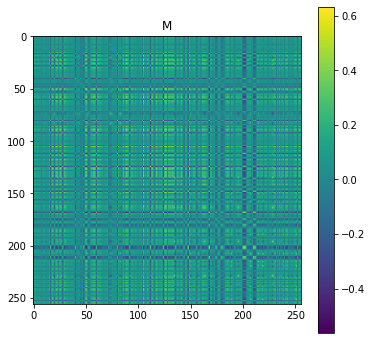

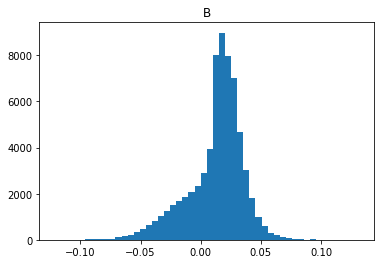

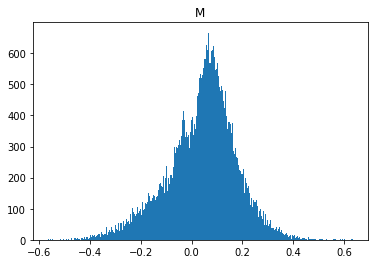

In [35]:
# display learned B and M
M = B.T @ B
display_matrix(B, 'B')
display_matrix(M, 'M')

# show some statistics of learned B and L
print('B_max = '+str(np.max(B))+'\tB_min = '+str(np.min(B)))
print('M_max = '+str(np.max(M))+'\tM_min = '+str(np.min(M)))

# show histogram of entries in B and L
hist_of_entries(B, 50, lx=None, lbl='B')
hist_of_entries(M, 500, lx=None, lbl='M')

In [36]:
def weights(f, B):
    """
    Create the adjacency matrix from B.
    
    Input: f, B
    f - CxN matrix of feature vectors (Cx1) for all N training images
    B - CxC matrix of parameters determining the covariance matrix (M=B.T @ B)
    
    Output: W
    W - NxN adjacency matrix of the similarity graph    
    """

    # create F
    f_sz, num_train = f.shape
    Fj = np.broadcast_to([f.T], (num_train, num_train, f_sz))
    Fi = np.transpose(Fj, (1,0,2))
    F = Fi - Fj
    
    # create M
    M = B.T @ B
    
    # create W
    W = np.zeros((num_train, num_train))
    for i in range(num_train):
        for j in range(num_train):
            if i==j:
                W[i][j] = 0
            else:
                W[i][j] = np.exp(-1*(F[i][j].T @ M @ F[i][j]))
                
                
    return W 

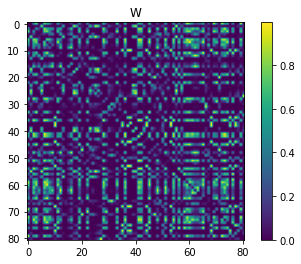

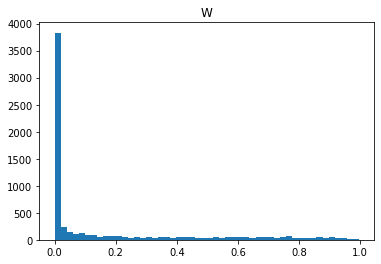

In [37]:
# show the graph's adjacency matrix
f = des_mod_nrm.T
W = weights(f, B)
_ = plt.figure()
_ = plt.imshow(W)
_ = plt.colorbar()
_ = plt.title('W')

# draw histogram of the graph's edge weights
_ = plt.figure()
_ = plt.hist(W.reshape(-1),50)
_ = plt.title('W')

In [38]:
def ordered(W, x):
    """
    Orders the adjacency matrix w.r.t. image labels. All 0's come first and then all 1's.
    
    Input: W, x
    W - NxN adjacency matrix of the similarity graph
    x - Nx1 vector of image labels (1 for 1; -1 for 0)
    
    Output: W_ord, order
    W_ord - NxN adjacency matrix where all 0-labeled nodes come first and then all 1-labeled nodes
    order - Nx1 vector showing order of images
    """
    
    order1 = np.arange(x.shape[0])
    
    W1 = W[x == -1, :]
    W1 = np.append(W1, W[x == 1, :], axis=0)
    
    W_ord = W1[:,x == -1]
    W_ord = np.append(W_ord, W1[:,x == 1], axis=1)
    
    order = order1[x == -1]
    order = np.append(order, order1[x == 1])
    
    return W_ord, order

There are 42 zero-labeled vertices and 39 one-labeled vertices.


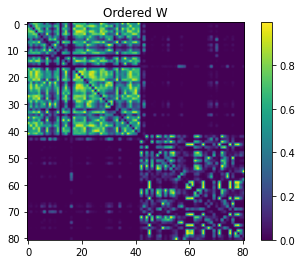

In [39]:
# show ordered adjacency matrix
x=train_y_mod*2-1
W_ord, order = ordered(W, x)
_ = plt.imshow(W_ord)
_ = plt.colorbar()
_ = plt.title('Ordered W')

print('There are {} zero-labeled vertices and {} one-labeled vertices.'.format(np.sum(x == -1), np.sum(x == 1)))

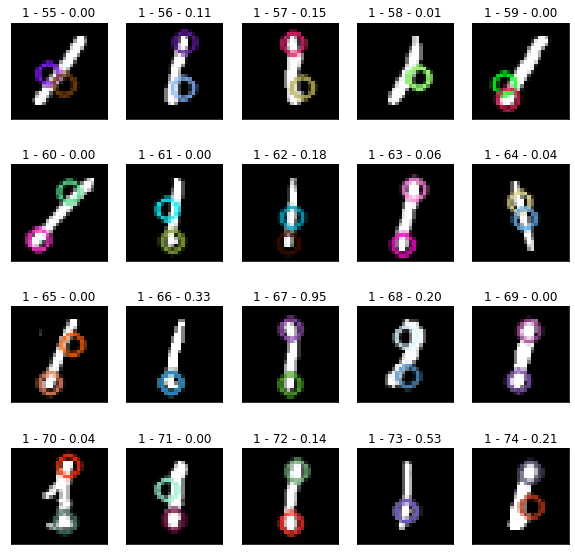

In [40]:
# visualize a few (problematic) keypoints
num_digits = 5
num_rows = 4
plt.figure(figsize=(10,10))
for i in range(num_rows*num_digits):
    ind = order[55+i]
    plt.subplot(num_rows,num_digits,i+1)
    img=cv.drawKeypoints(gray_mod[ind],kp_mod[ind],0)
    #img=cv.drawKeypoints(gray_mod[ind],kp_mod[ind],0,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    display_color_image(img, str(train_y_mod[ind])+' - '+str(55+i)+' - {:.2f}'.format(W_ord[55+i][50]))

### Issue: selected keypoints are not describing the same locations in different images. For exaple, a key point on the end of a line has a vastly different descriptor than a keypoint on the edge of the same line.

# Bring it all together